In [1]:
## Download and preprocess TF motifs from databases
## CIS-BP 2.0
## JASPAR 2020
## BANP motif from Grand2021
## see 'runall' script in each databases/*/ folder for pre-preproccing steps.

## After pre-processing all of the invdividual databases run
##      bin/runall.tomtom.v2.0beta-human
## to compute the pair-wise similarity for all the motifs.
## Results are stored in 'results/tomtom'.


In [2]:
import pandas as pd
import numpy as np

In [3]:
# Import JASPAR2020 metadata

# These are the human only motifs; used the JASPAR search tool on website and downloaded all motifs from cart
jaspar2020 = !grep "MOTIF" /tf_clustering/files/JASPAR2020_CORE_vertebrates_non-redundant_pfms_meme.txt | cut -d" " -f2

# Only get JASPAR motifs not in CIS-BP
# Note: some Taipale motifs are present in the JASPAR that might also be in CIS-BP

jaspar_motifs = list(set(jaspar2020))

from pyjaspar import jaspardb
jdb_obj = jaspardb(release='JASPAR2020')

motif_id = []
dbid = []
tf_name = []
tf_family_name = []
pmid = []
motif_type = []

for m in jaspar_motifs:
    motif = jdb_obj.fetch_motif_by_id(m)
    
    motif_id.append(m)
    dbid.append(m)
    
    tf_name.append(motif.name)
    tf_family_name.append(motif.tf_class)
    pmid.append(motif.medline)
    motif_type.append('Unknown')
    
jaspar2020_df = pd.DataFrame(
    {
        'motif_id': motif_id,
        'source_id': dbid,
        'tf_name': tf_name,
        'family_name': tf_family_name,
        'motif_type': motif_type,
        'PMID': pmid
    }
).set_index('motif_id')



In [5]:
#Combine motif metadata.

motifs = jaspar_motifs
len(motifs)

df_motif_info = pd.concat([jaspar2020_df])
df_motif_info['motif_type'].value_counts()

Unknown    746
Name: motif_type, dtype: int64

In [6]:
df_motif_info.loc['MA0139.1']

source_id                        MA0139.1
tf_name                              CTCF
family_name    [C2H2 zinc finger factors]
motif_type                        Unknown
PMID                             17512414
Name: MA0139.1, dtype: object

In [7]:
# Load up the TOMTOM results
tomtom = pd.read_table('/tf_clustering/files/JASPARv2020.tomtom.out').rename(columns={'#Query ID': 'Query ID'})
sim = tomtom.pivot_table(index='Query ID', columns='Target ID', values='E-value', fill_value=np.nan)
cols = sim.columns.intersection(motifs)
rows = sim.index.intersection(motifs)

sim = sim[cols].loc[rows]

x = sim.values

w = np.triu(x) +  np.triu(x, 1).T
v = np.tril(x) + np.tril(x, -1).T

sim.iloc[:,:] = np.nanmin(np.dstack([w, v]), axis=2)


/var/folders/mr/1g92sxzs1wj2my0bkk2rwzbw0000gn/T/ipykernel_45669/3645486120.py:14: RuntimeWarning: All-NaN slice encountered
  sim.iloc[:,:] = np.nanmin(np.dstack([w, v]), axis=2)


In [8]:
sim.fillna(100, inplace=True)
sim = -np.log10(sim)
sim[np.isinf(sim)] = 10

/.pyenv/versions/3.8.7/lib/python3.8/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


In [9]:
sim

Target ID   MA0002.2   MA0003.4  MA0004.1  MA0006.1   MA0007.3  MA0009.2  \
Query ID                                                                   
MA0002.2   12.795305  -0.609977 -2.000000 -2.000000  -2.000000      -2.0   
MA0003.4   -0.609977  19.798081 -2.000000 -2.000000  -2.000000      -2.0   
MA0004.1   -2.000000  -2.000000  6.376220 -0.846428  -2.000000      -2.0   
MA0006.1   -2.000000  -2.000000 -0.846428  5.537614  -2.000000      -2.0   
MA0007.3   -2.000000  -2.000000 -2.000000 -2.000000  21.266341      -2.0   
...              ...        ...       ...       ...        ...       ...   
MA1654.1   -2.000000  -2.000000 -2.000000 -2.000000  -2.000000      -2.0   
MA1655.1   -2.000000  -2.000000 -2.000000 -2.000000  -2.000000      -2.0   
MA1656.1   -2.000000  -2.000000 -2.000000 -2.000000  -2.000000      -2.0   
MA1657.1   -2.000000  -2.000000 -2.000000 -2.000000  -2.000000      -2.0   
MA1683.1   -2.000000  -2.000000 -2.000000 -2.000000  -2.000000      -2.0   

Target ID  MA0014.3  MA0017.2  MA0018.4  MA0019.1  ...  MA1649.1  MA1650.1  \
Query ID                                           ...                       
MA0002.2  -2.000000  -2.00000      -2.0      -2.0  ...      -2.0      -2.0   
MA0003.4  -2.000000  -2.00000      -2.0      -2.0  ...      -2.0      -2.0   
MA0004.1  -1.371692  -2.00000      -2.0      -2.0  ...      -2.0      -2.0   
MA0006.1   0.651218  -2.00000      -2.0      -2.0  ...      -2.0      -2.0   
MA0007.3  -2.000000  -2.00000      -2.0      -2.0  ...      -2.0      -2.0   
...             ...       ...       ...       ...  ...       ...       ...   
MA1654.1  -2.000000  -2.00000      -2.0      -2.0  ...      -2.0      -2.0   
MA1655.1  -2.000000  -2.00000      -2.0      -2.0  ...      -2.0      -2.0   
MA1656.1  -2.000000  -2.00000      -2.0      -2.0  ...      -2.0      -2.0   
MA1657.1  -2.000000  -1.23857      -2.0      -2.0  ...      -2.0      -2.0   
MA1683.1  -2.000000  -2.00000      -2.0      -2.0  ...      -2.0      -2.0   

Target ID  MA1651.1  MA1652.1  MA1653.1   MA1654.1   MA1655.1   MA1656.1  \
Query ID                                                                   
MA0002.2  -2.000000      -2.0      -2.0  -2.000000  -2.000000  -2.000000   
MA0003.4  -2.000000      -2.0      -2.0  -2.000000  -2.000000  -2.000000   
MA0004.1  -2.000000      -2.0      -2.0  -2.000000  -2.000000  -2.000000   
MA0006.1  -2.000000      -2.0      -2.0  -2.000000  -2.000000  -2.000000   
MA0007.3  -2.000000      -2.0      -2.0  -2.000000  -2.000000  -2.000000   
...             ...       ...       ...        ...        ...        ...   
MA1654.1   1.621509      -2.0      -2.0  31.167945  -2.000000  -2.000000   
MA1655.1  -2.000000      -2.0      -2.0  -2.000000  15.831844  -2.000000   
MA1656.1  -2.000000      -2.0      -2.0  -2.000000  -2.000000  15.197106   
MA1657.1  -2.000000      -2.0      -2.0  -2.000000  -2.000000  -2.000000   
MA1683.1  -2.000000      -2.0      -2.0  -2.000000  -2.000000  -2.000000   

Target ID   MA1657.1   MA1683.1  
Query ID                         
MA0002.2   -2.000000  -2.000000  
MA0003.4   -2.000000  -2.000000  
MA0004.1   -2.000000  -2.000000  
MA0006.1   -2.000000  -2.000000  
MA0007.3   -2.000000  -2.000000  
...              ...        ...  
MA1654.1   -2.000000  -2.000000  
MA1655.1   -2.000000  -2.000000  
MA1656.1   -2.000000  -2.000000  
MA1657.1   21.404388  -2.000000  
MA1683.1   -2.000000  16.272351  

[746 rows x 746 columns]

In [10]:
# Cluster the square matrix

from scipy.cluster.hierarchy import fcluster, linkage, dendrogram

Z = linkage(sim, method = 'complete', metric = 'correlation')

cl = fcluster(Z, 0.7, criterion='distance')
o = dendrogram(Z, no_plot=True)['leaves']

print(f'Number of motif clusters: {max(cl)}')

motif_annot_df = pd.DataFrame({'motif_id':sim.index, 'cluster':cl}).merge(df_motif_info.reset_index(), on='motif_id', how='left').set_index('motif_id')
motif_annot_df['cluster'] = 'AC' + motif_annot_df['cluster'].astype(str).str.zfill(4)
motif_annot_df.head()

Number of motif clusters: 150


cluster source_id    tf_name  \
motif_id                                
MA0002.2  AC0135  MA0002.2      RUNX1   
MA0003.4  AC0147  MA0003.4     TFAP2A   
MA0004.1  AC0058  MA0004.1       Arnt   
MA0006.1  AC0057  MA0006.1  Ahr::Arnt   
MA0007.3  AC0087  MA0007.3         Ar   

                                                family_name motif_type  \
motif_id                                                                 
MA0002.2                              [Runt domain factors]    Unknown   
MA0003.4            [Basic helix-span-helix factors (bHSH)]    Unknown   
MA0004.1            [Basic helix-loop-helix factors (bHLH)]    Unknown   
MA0006.1  [Basic helix-loop-helix factors (bHLH), Basic ...    Unknown   
MA0007.3           [Nuclear receptors with C4 zinc fingers]    Unknown   

              PMID  
motif_id            
MA0002.2         -  
MA0003.4  23332764  
MA0004.1   7592839  
MA0006.1   7592839  
MA0007.3  20943813

In [11]:
motif_annot_df[motif_annot_df['source_id']=='MA0139.1']

cluster source_id tf_name                 family_name motif_type  \
motif_id                                                                    
MA0139.1  AC0140  MA0139.1    CTCF  [C2H2 zinc finger factors]    Unknown   

              PMID  
motif_id            
MA0139.1  17512414

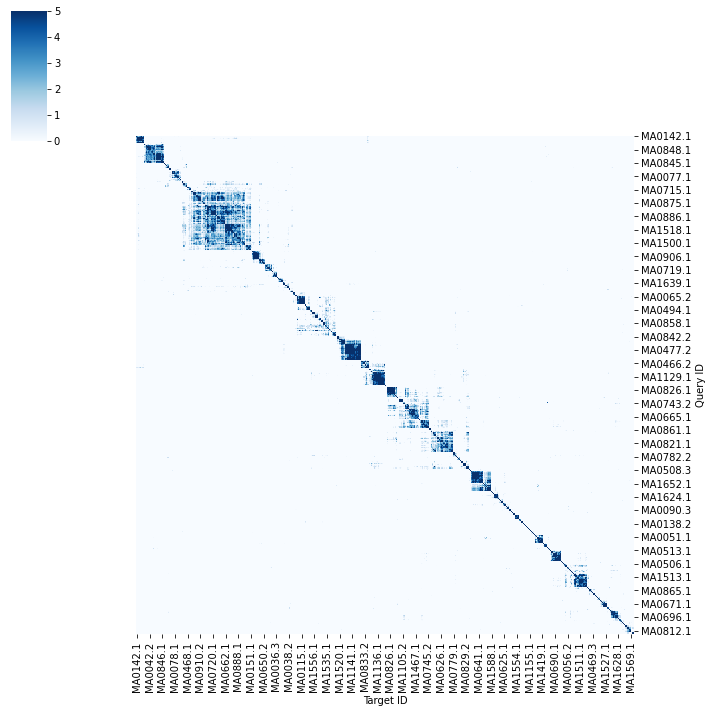

In [12]:
# Heatmap plot

import matplotlib.pyplot as plt
import seaborn as sns

sns.clustermap(sim.iloc[o,o], vmin=0, vmax=5, row_cluster=False, col_cluster=False, cmap='Blues')

plt.savefig('/tf_clustering/files/heatmap.png')

In [48]:
def relative_info_content(pwm):
    p = pwm/np.sum(pwm, axis = 1)[:,np.newaxis]
    ic = 2+np.sum(p*np.nan_to_num(np.log2(p)), axis = 1)
    ric = p*ic[:,np.newaxis]
    return ric

import warnings
warnings.filterwarnings('ignore')

def abs_mean(x):
    return np.mean(np.abs(x))

def process_cluster(df, tomtom_df):
    
    import os.path
    
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as mgridspec
    
    from genome_tools.plotting import sequence
    
    #seed_motif = df.index[0]
    motifs = df.index
    #rows = (tomtom_df['Query ID'] == seed_motif) & (tomtom_df['Target ID'].isin(motifs))
    #pairwise_df = tomtom_df[rows]
    
    rows = (tomtom_df['Query ID'].isin(motifs)) & (tomtom_df['Target ID'].isin(motifs))
    pairwise_df = tomtom_df[rows]        
    
    seed_motif = pairwise_df.groupby('Query ID').agg({'Optimal offset': abs_mean}).sort_values('Optimal offset').index[0]
    rows = (tomtom_df['Query ID'] == seed_motif) & (tomtom_df['Target ID'].isin(motifs))
    
    pairwise_df = tomtom_df[rows] 
    
    w = pairwise_df['Target consensus'].str.len()
    left = min(-pairwise_df['Optimal offset'])
    l_offset = -left - pairwise_df['Optimal offset']
    right = max(l_offset + w)
    r_offset = right - w - l_offset
    
    alignment_df = pairwise_df.drop(['Query ID', 'Optimal offset', 'p-value', 'E-value', 'q-value', 'Overlap', 'Query consensus'], axis=1)
    alignment_df.loc[:,'w'] = w
    alignment_df.loc[:,'l_offset'] = l_offset
    alignment_df.loc[:,'r_offset'] = r_offset
    alignment_df.columns = ['motif', 'consensus', 'strand', 'w', 'l_offset', 'r_offset']
    
    alignment_df.reset_index(drop=True, inplace=True)

    alignment_df = alignment_df.merge(df.reset_index(), left_on='motif', right_on='motif_id')
    
    alignment_df.sort_values(by='tf_name', inplace=True)
    alignment_df.reset_index(inplace=True)

    
    n = len(alignment_df)
    l = min(alignment_df['l_offset'])
    r = max(alignment_df['r_offset'] + alignment_df['w'])
    w = r - l
    
    summed_pwm = np.zeros((4, w))
    
    for i, row in alignment_df.iterrows():
        
        motif_id = row['motif']
        rc = row['strand'] == '-'
        left = row['l_offset']
        width = row['w']

        motif_pfm = os.path.join('/tf_clustering/files/pfms/', motif_id + '.pfm')
        pwm = np.loadtxt(motif_pfm)
    
        if rc:
            pwm = pwm[::-1,::-1]
            
        extended_pwm = np.ones((4, w)) * 0.25
        extended_pwm[:,left:left+width] = pwm

        summed_pwm += extended_pwm
        
    avg_pwm = (summed_pwm/n).T
 
    ic = relative_info_content(avg_pwm)
    total_ic = ic.sum(axis=1)

    cdf = np.cumsum(total_ic)/np.sum(total_ic)
    s = np.where(cdf > 0.05)[0][0]
    e = np.where(cdf > 0.95)[0][0] + 1    

    avg_pwm = avg_pwm[s:e,:]
    
    ## plot
    
    fig = plt.figure()
    fig.set_size_inches((w+2)*.125+2, (n+1)*0.5+1)
    
    gs = mgridspec.GridSpec(n+1, 1)
    
    for i, row in alignment_df.iterrows():
        ax = fig.add_subplot(gs[i+1, :])
        
        motif_id = row['motif']
        rc = row['strand'] == '-'
        left = row['l_offset']
        width = row['w']

        motif_pfm = os.path.join('/tf_clustering/files/pfms/', motif_id + '.pfm')
        pwm = np.loadtxt(motif_pfm)
    
        if rc:
            pwm = pwm[::-1,::-1]
        
        sequence.seq_plot(relative_info_content(pwm.T), ax=ax, offset=left)

        ax.axvspan(l-1, s, fc='lightgrey', alpha=0.5)
        ax.axvspan(e, r+1, fc='lightgrey', alpha=0.5)
        
        ax.set_xlim(left=l-1, right=r+1)
        ax.set_ylim(bottom=0, top=2.1)

        ax.xaxis.set_visible(False)
        ax.set_yticks([])
        
        source_id = str(row['source_id'])
        source_id = source_id[:10] + '...' if len(source_id) > 10 else source_id
        tf_name = str(row['tf_name'])  + '(' + str(row['motif_type']) + ')'

        ax.set_ylabel(tf_name + '\n (' + source_id + ')', rotation=0, ha='right', va='center', fontname="IBM Plex Mono", fontsize='medium')

    # Archetype motif
    ax = fig.add_subplot(gs[0,:])

    sequence.seq_plot(relative_info_content(avg_pwm), ax=ax, offset=s)

    ax.set_xlim(left=l-1, right=r+1)
    ax.set_ylim(bottom=0, top=2.1)
    ax.xaxis.set_visible(False)
    ax.set_yticks([])

    ax.axvspan(s, e, fc='none', ec='r', lw=2, clip_on=False)
    [ax.spines[loc].set_visible(False) for loc in ['top', 'bottom', 'left', 'right']]

    ax.set_ylabel('Archetype\nconsensus', rotation=0, ha='right', va='center', fontname="IBM Plex Mono", fontsize='large', fontweight='bold', color='r')
    
    cluster_id = str(alignment_df['cluster'][0])
    gene_family = alignment_df['tf_name'].str.replace('[\-0-9]+$', '').value_counts().index[:2].str.cat(sep='/')
    dbd = alignment_df['family_name'].astype(str).value_counts().index[0].replace(' ', '_')
    cluster_name = cluster_id + ':' + gene_family + ':' + dbd

    figw, figh = fig.get_size_inches()
    height_frac = (figh-0.75)/figh
    
   
    
    gs.update(left=1-((figw-1.75)/figw), right=(figw-0.25)/figw, top=(figh-0.75)/figh, bottom=1-((figh-0.25)/figh))
    
    fig.suptitle(cluster_name.upper(), fontname="IBM Plex Mono", fontweight='bold', fontsize='large', y=1-(.5/figh), va='center')
    plt.savefig(f'/tf_clustering/files/clusters/{cluster_id}.pdf')
    plt.savefig(f'/tf_clustering/files/clusters/{cluster_id}.png')
    
    #
    w = avg_pwm.shape[0]
    
    fig = plt.figure()
    #fig.set_size_inches(w*0.125+0.5, 0.75)
    fig.set_size_inches(w*0.125, 0.5)
    
    figw, figh = fig.get_size_inches() 
    
    gs = mgridspec.GridSpec(1, 1)
    #gs.update(left=1-((figw-0.25)/figw), right=(figw-0.25)/figw, top=1-(0.25/figh), bottom=0)
    gs.update(left=0, right=1, top=1, bottom=0)

    ax = fig.add_subplot(gs[:,:])
    
    sequence.seq_plot(relative_info_content(avg_pwm), ax=ax)
    
    ax.set_xlim(left=0, right=w)
    ax.set_ylim(bottom=0, top=2.1)
    
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
    [ax.spines[loc].set_visible(False) for loc in ['top', 'bottom', 'left', 'right']]
    
    plt.savefig(f'/tf_clustering/files/clusters/logos/{cluster_id}.pdf')
    plt.savefig(f'/tf_clustering/files/clusters/logos/{cluster_id}.png')
    
    header_line =  cluster_name + '\n'
    mat = pd.DataFrame(avg_pwm.T, index=['A:', 'C:', 'G:', 'T:']).to_string(header=False)
    return header_line + mat

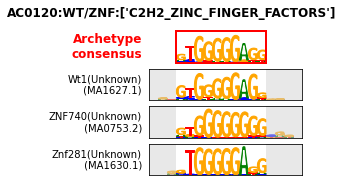

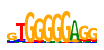

In [49]:
cluster = 'AC0120'

df = motif_annot_df.groupby('cluster').get_group(cluster)

pwm = process_cluster(df, tomtom)


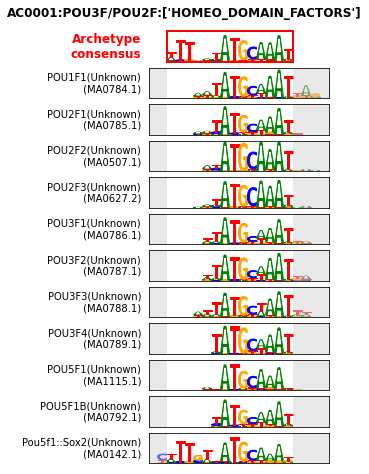

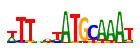

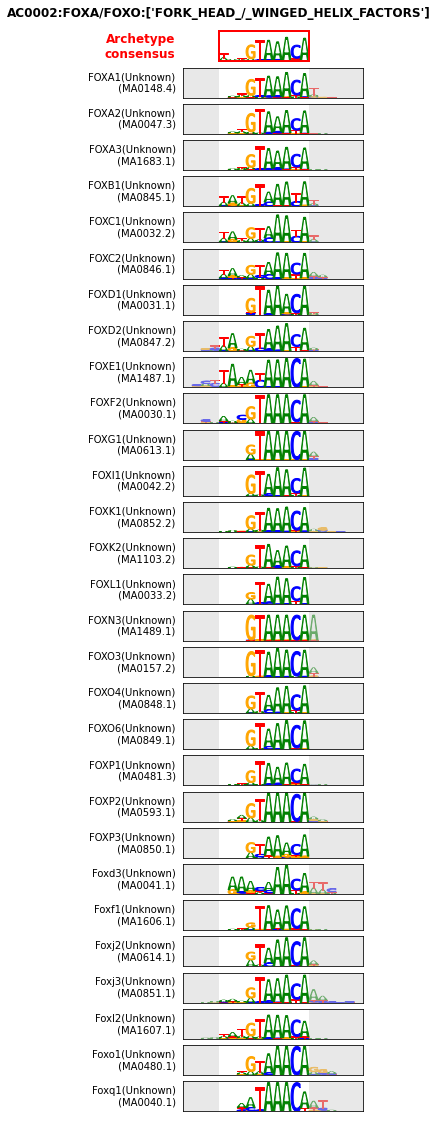

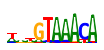

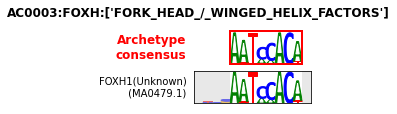

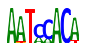

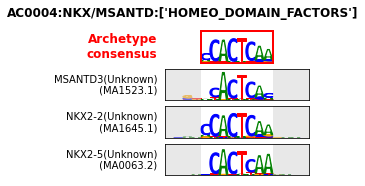

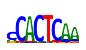

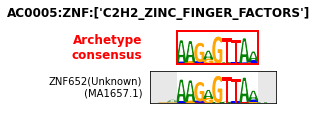

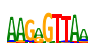

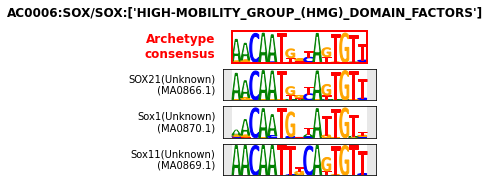

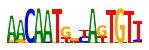

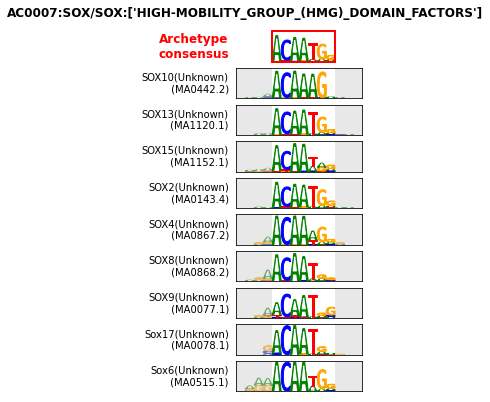

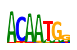

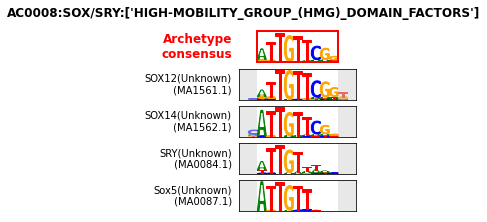

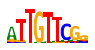

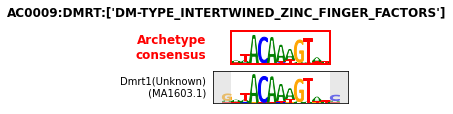

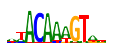

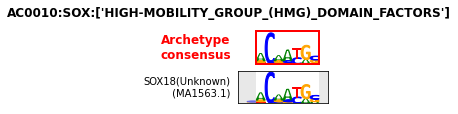

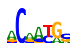

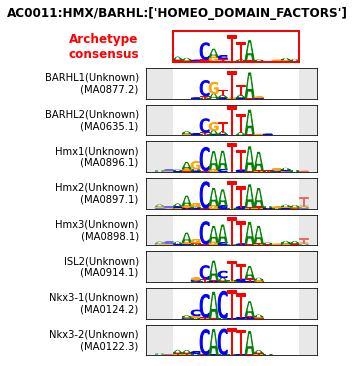

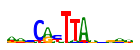

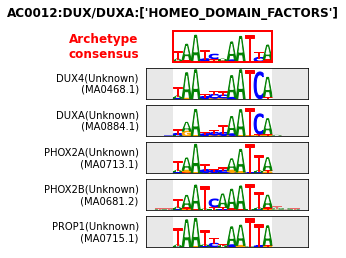

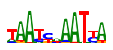

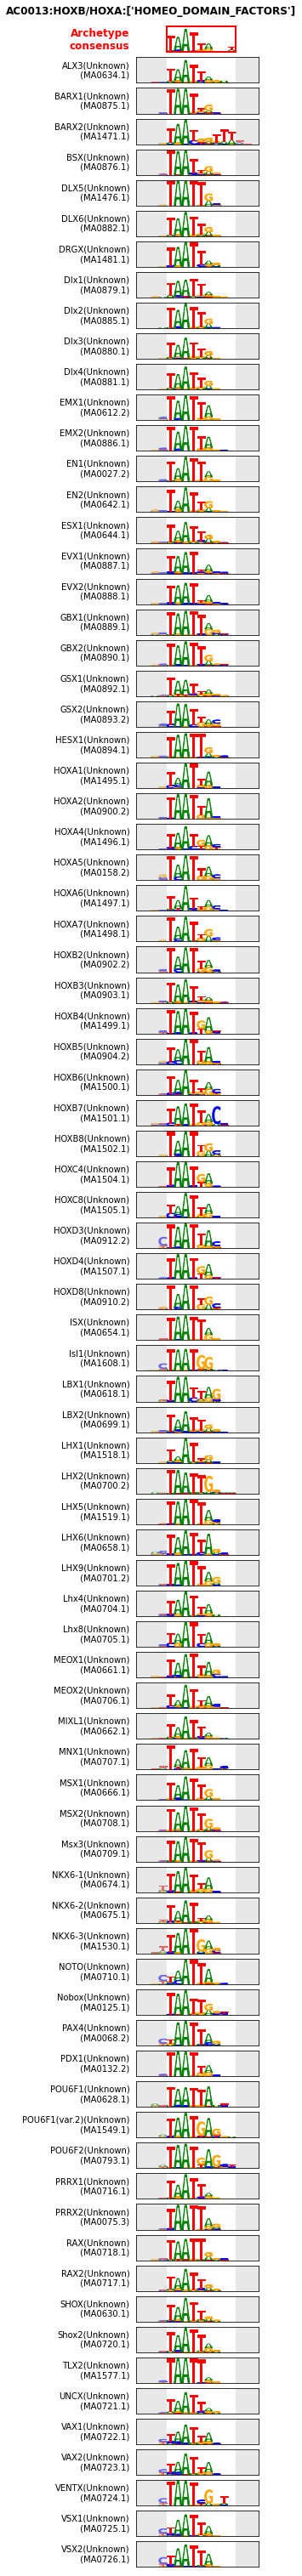

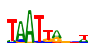

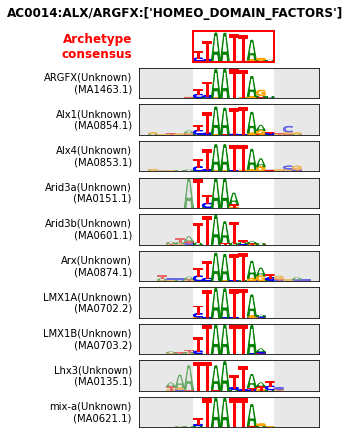

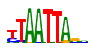

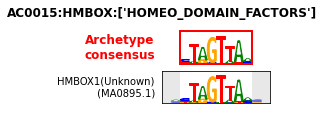

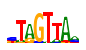

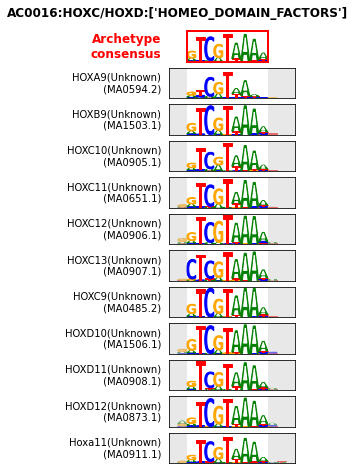

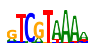

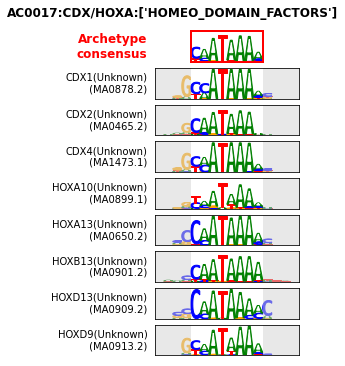

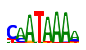

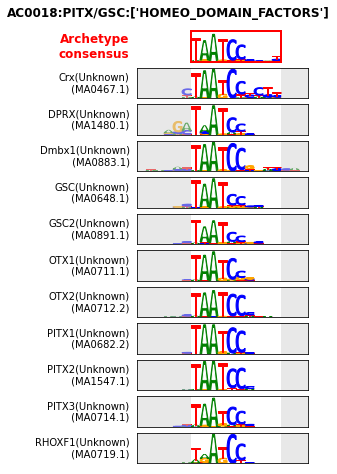

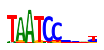

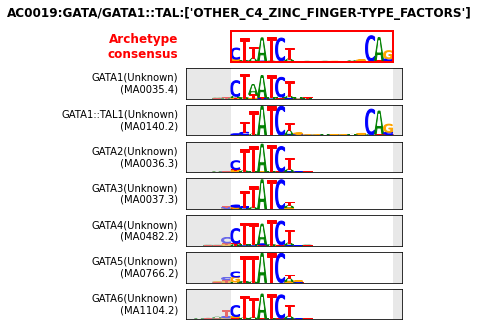

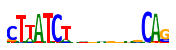

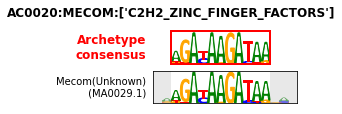

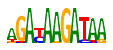

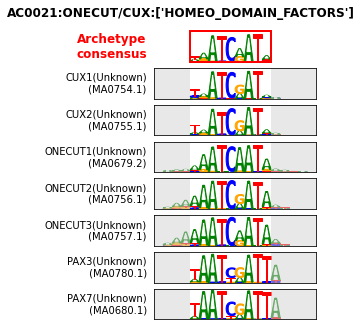

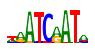

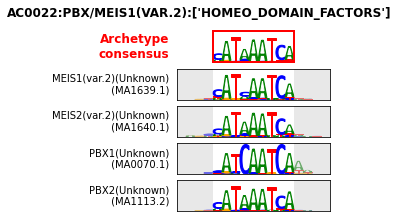

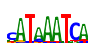

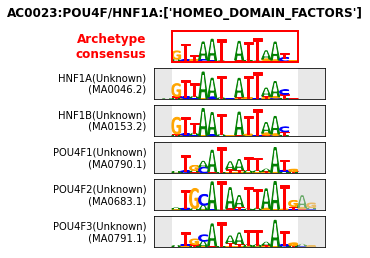

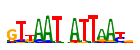

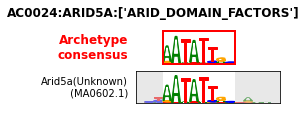

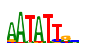

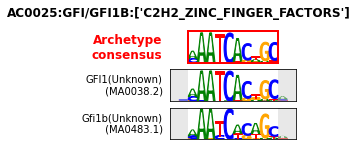

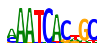

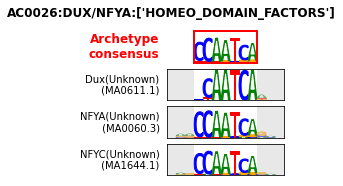

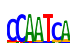

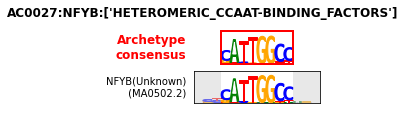

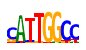

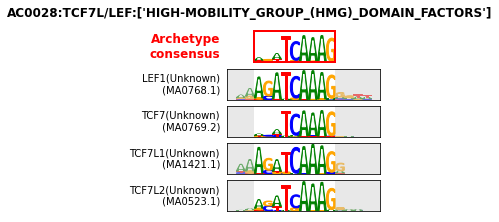

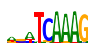

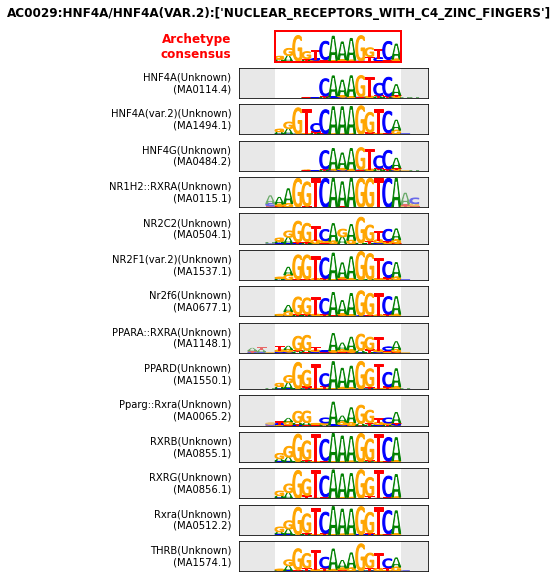

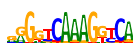

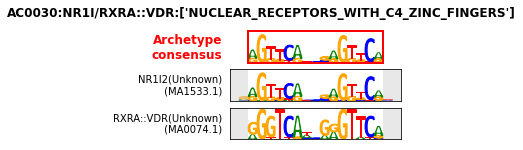

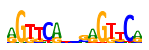

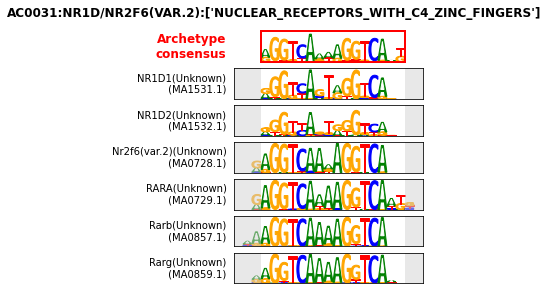

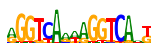

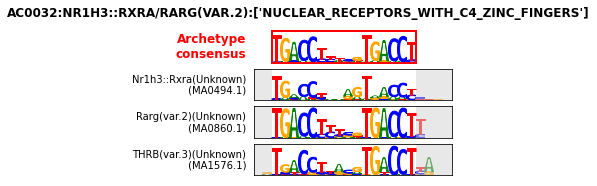

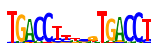

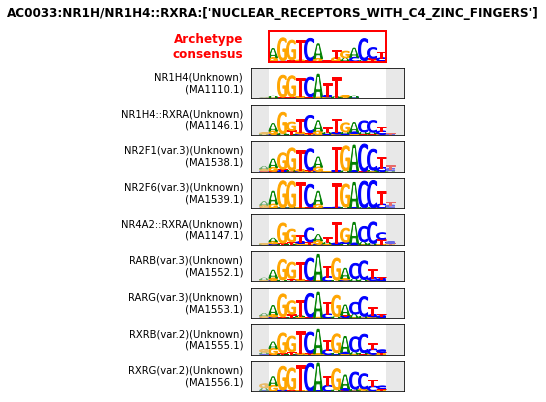

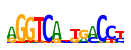

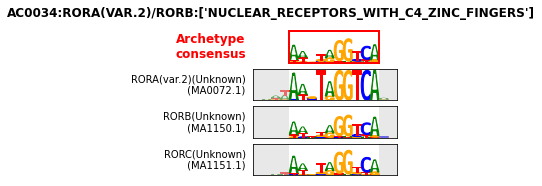

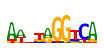

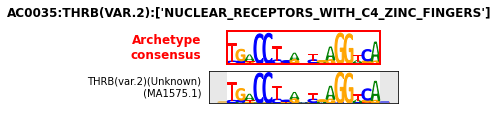

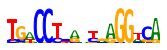

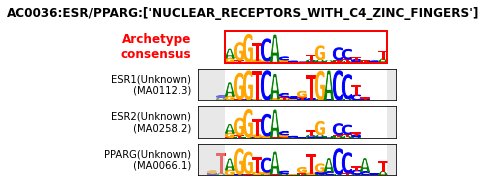

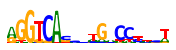

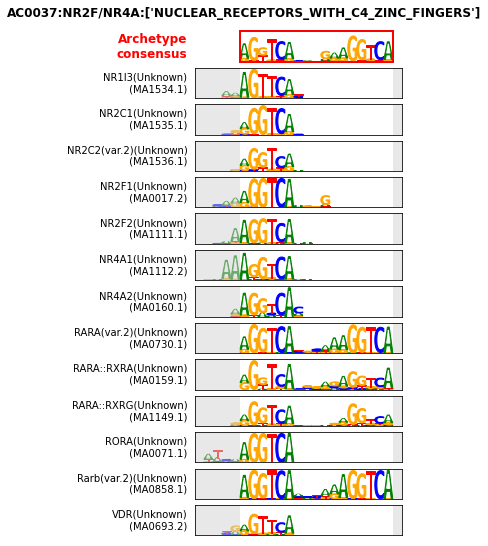

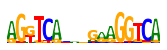

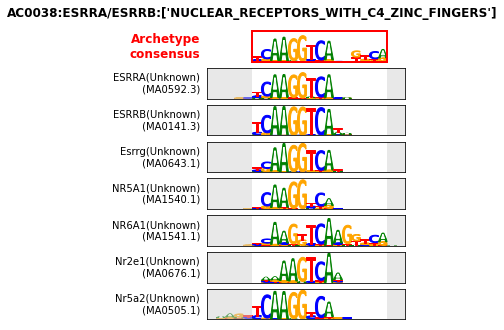

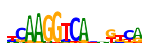

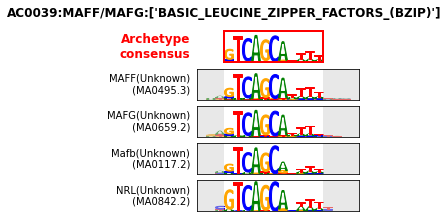

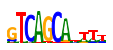

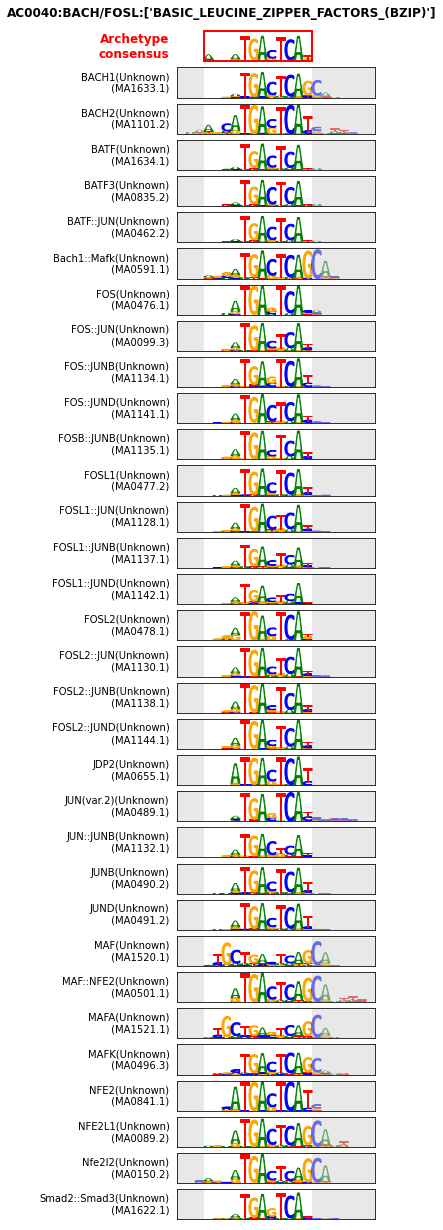

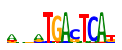

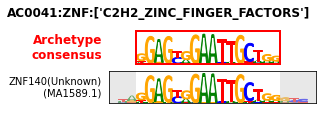

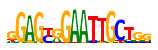

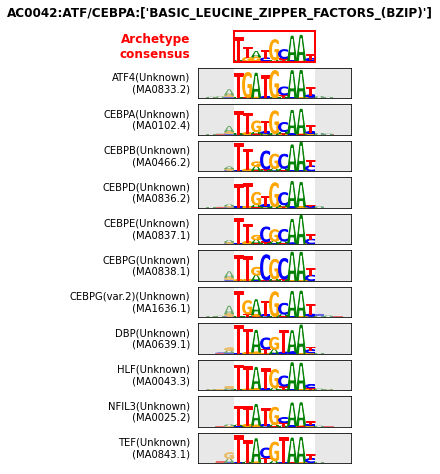

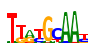

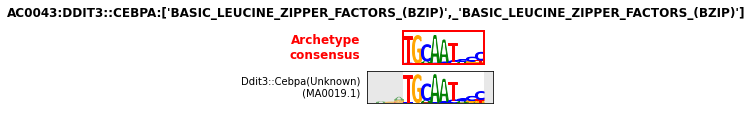

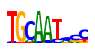

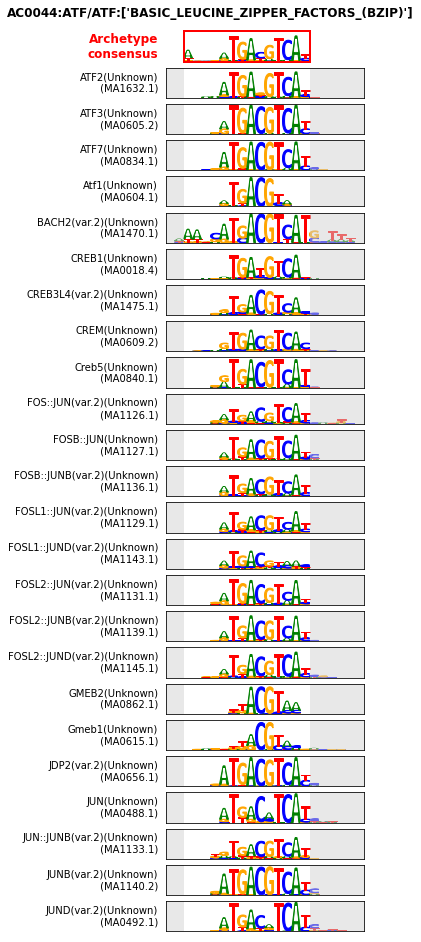

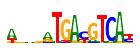

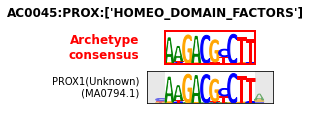

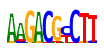

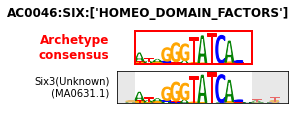

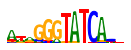

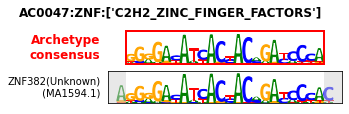

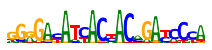

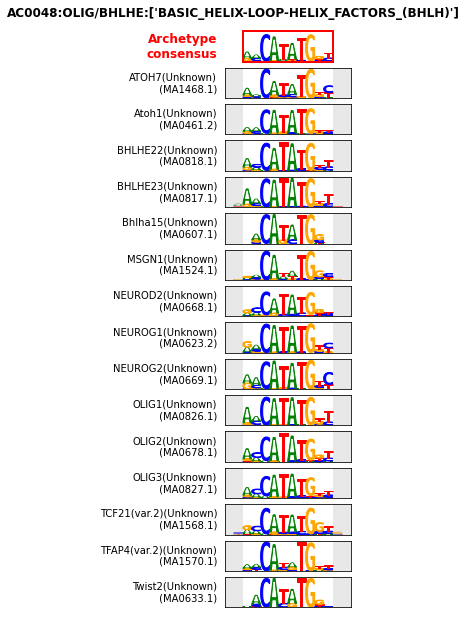

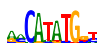

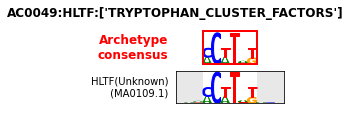

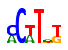

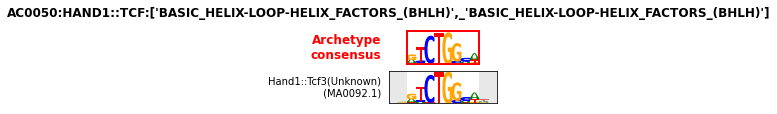

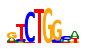

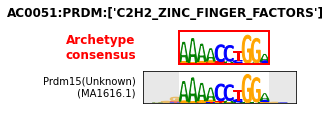

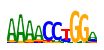

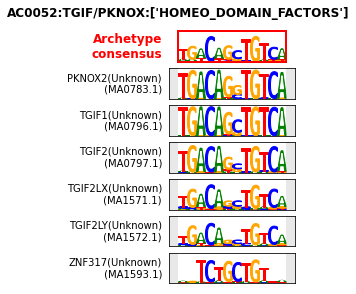

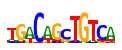

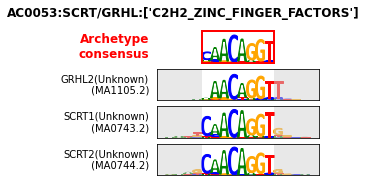

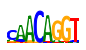

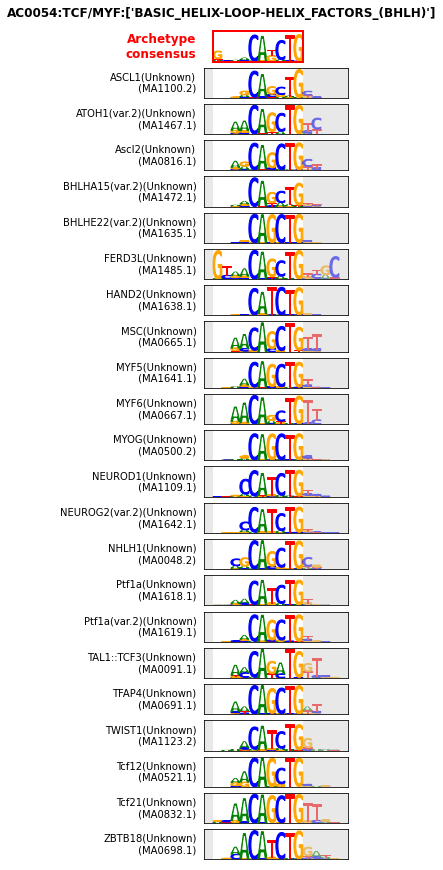

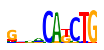

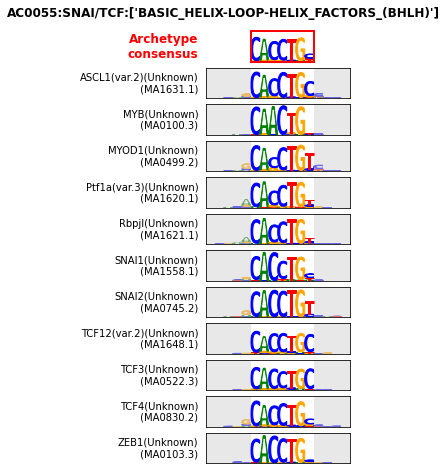

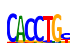

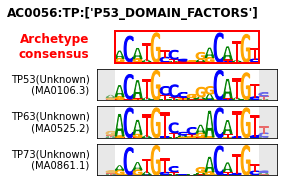

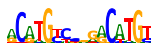

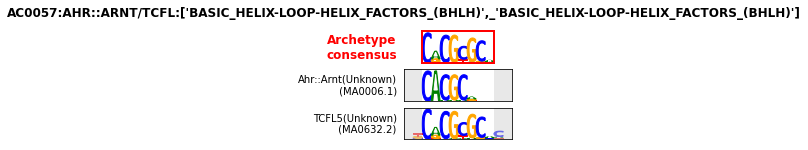

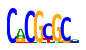

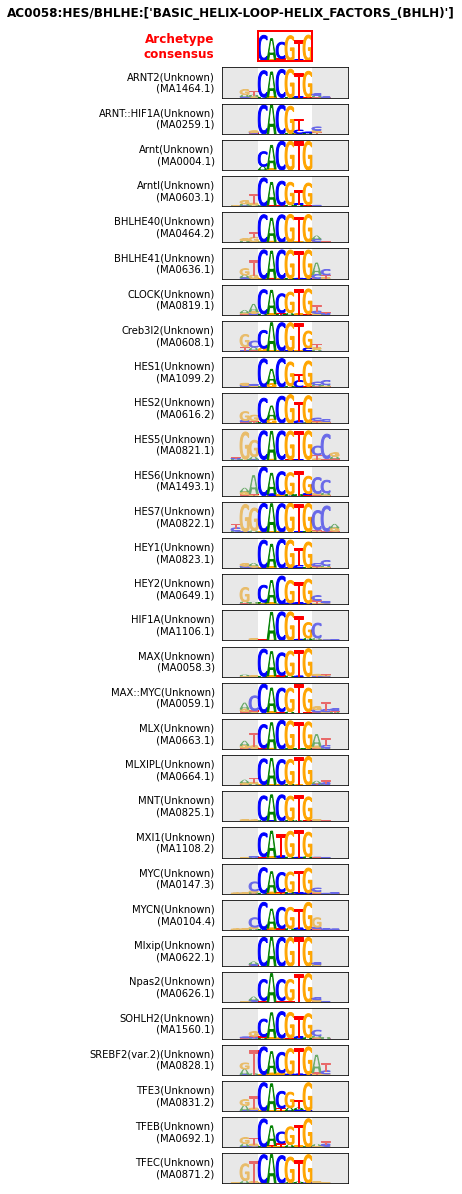

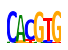

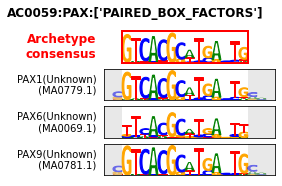

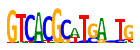

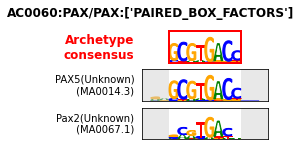

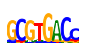

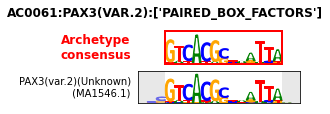

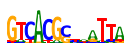

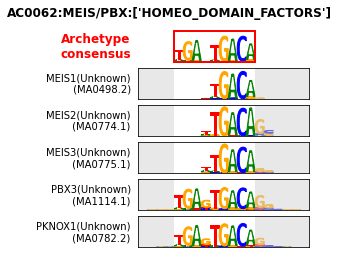

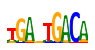

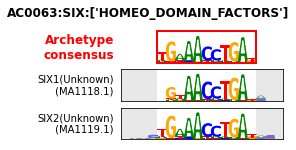

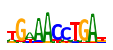

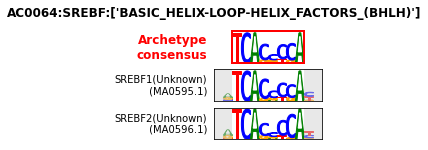

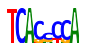

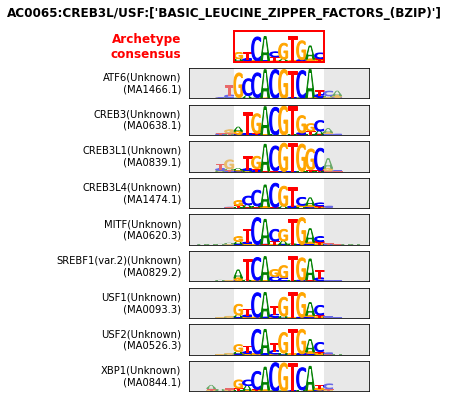

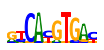

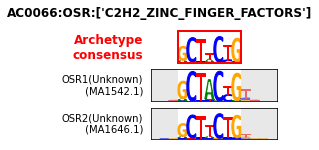

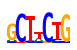

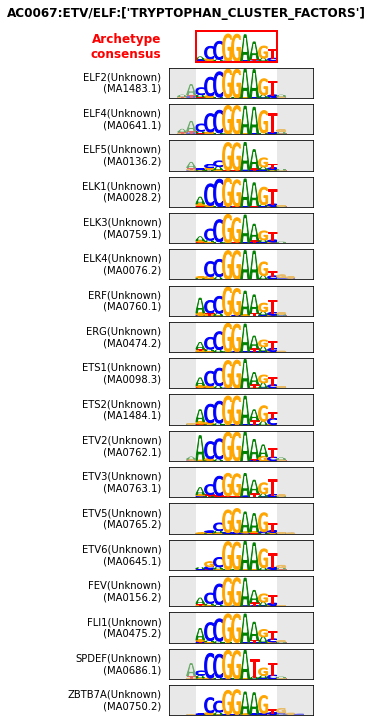

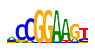

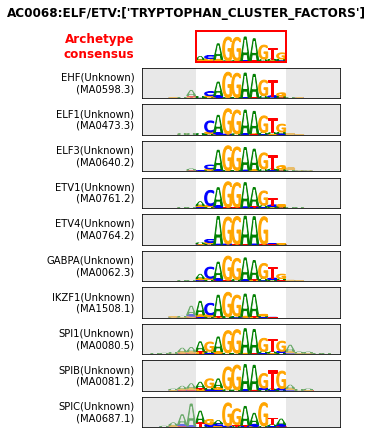

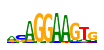

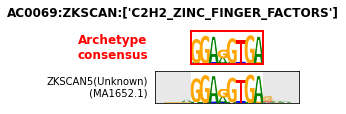

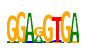

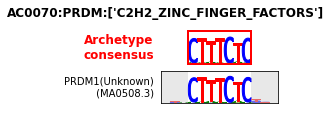

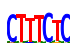

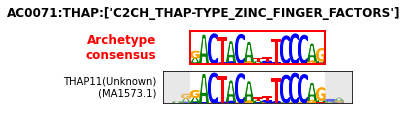

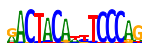

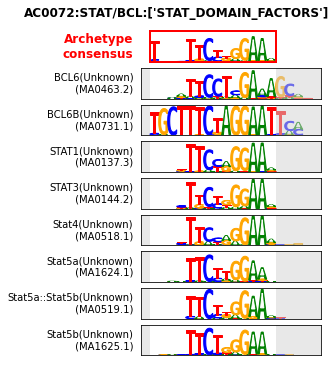

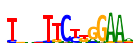

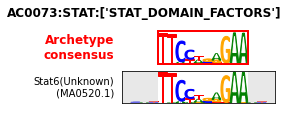

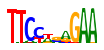

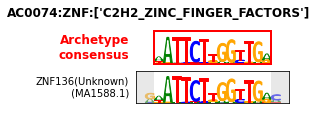

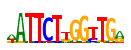

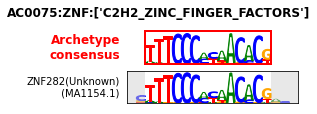

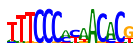

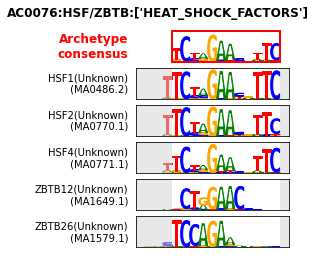

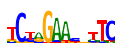

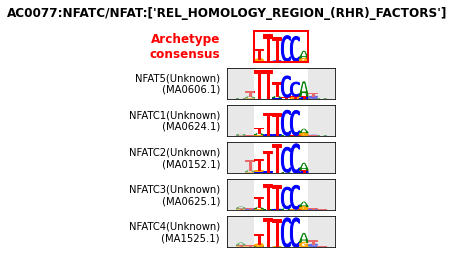

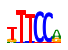

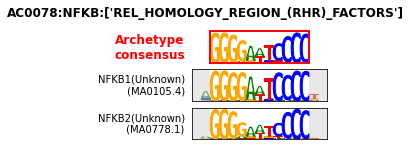

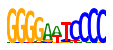

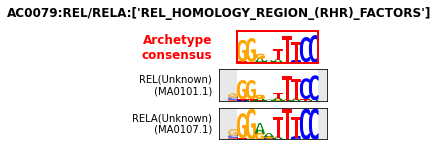

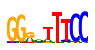

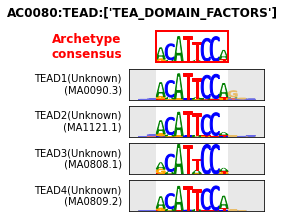

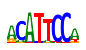

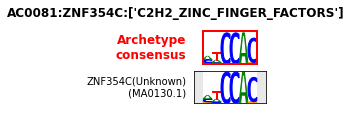

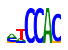

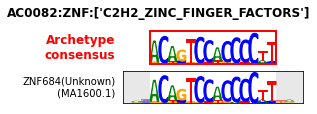

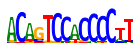

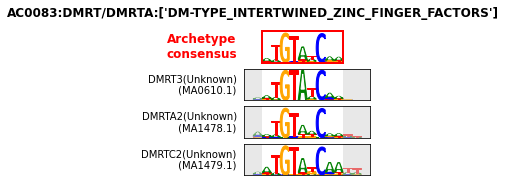

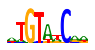

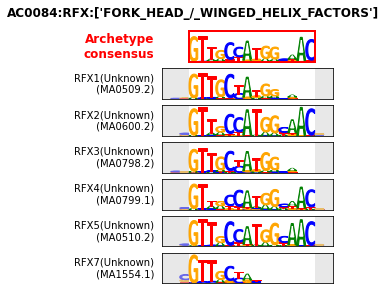

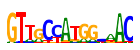

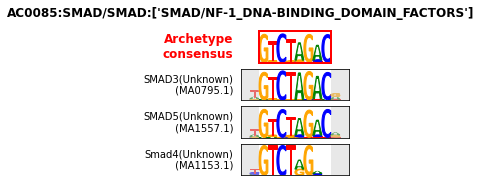

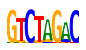

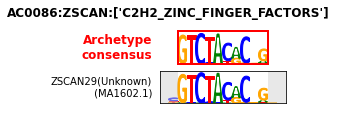

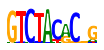

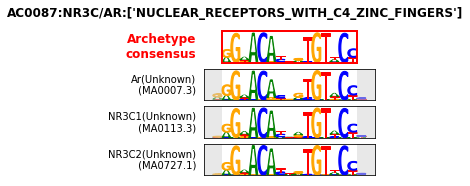

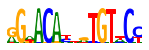

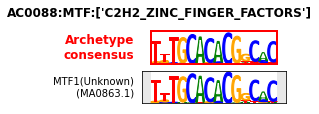

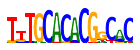

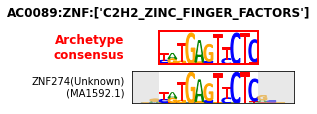

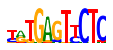

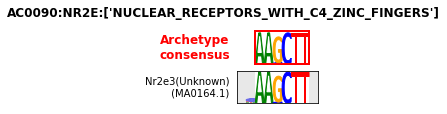

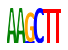

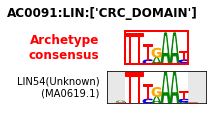

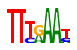

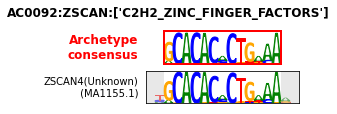

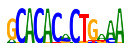

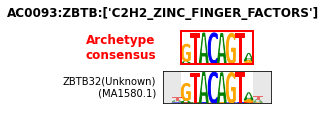

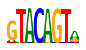

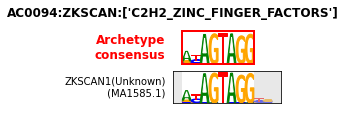

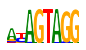

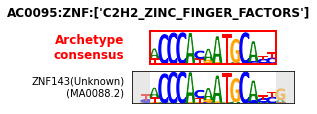

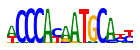

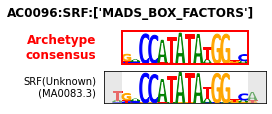

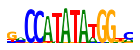

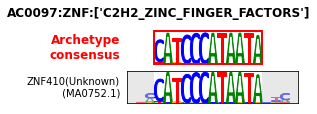

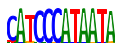

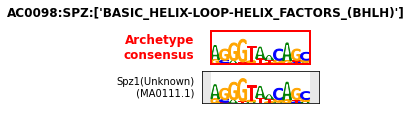

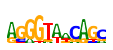

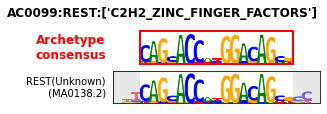

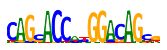

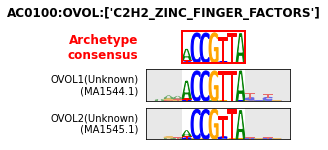

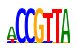

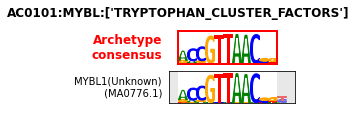

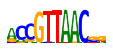

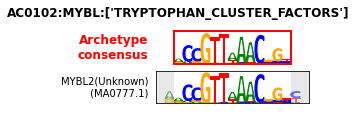

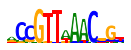

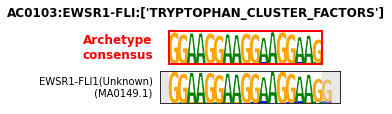

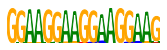

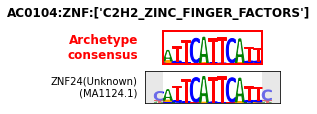

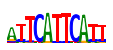

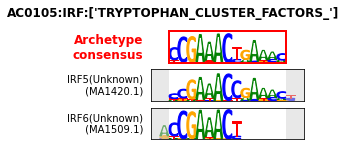

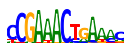

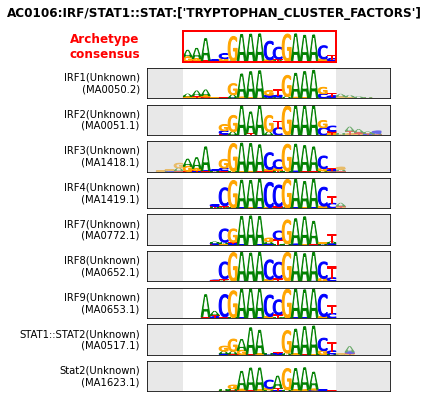

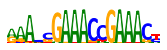

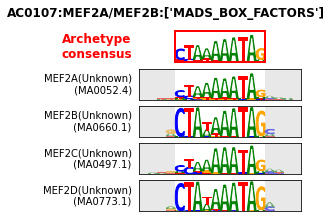

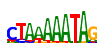

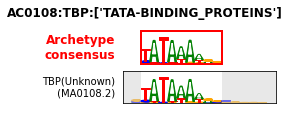

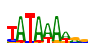

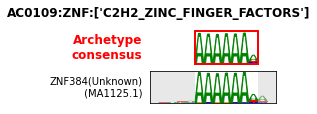

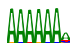

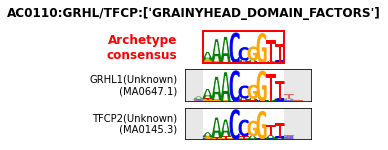

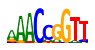

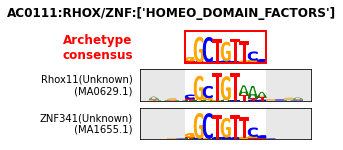

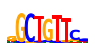

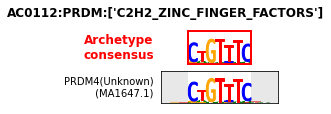

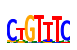

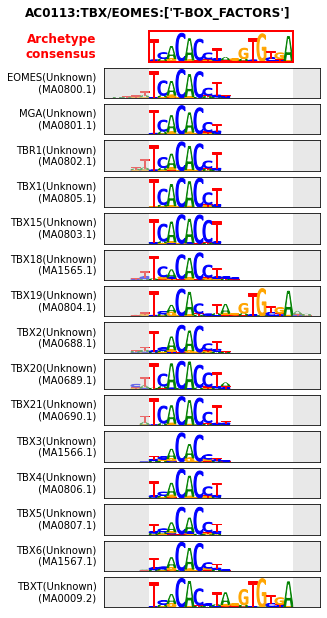

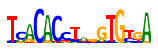

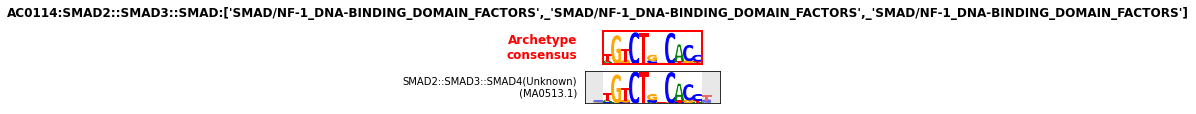

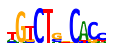

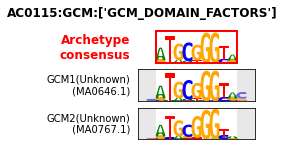

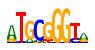

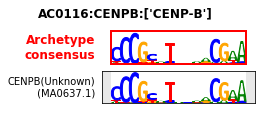

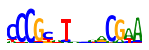

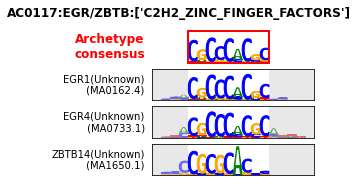

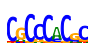

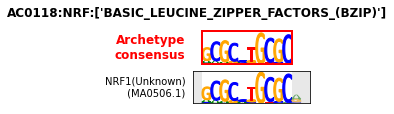

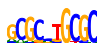

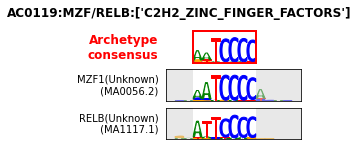

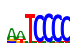

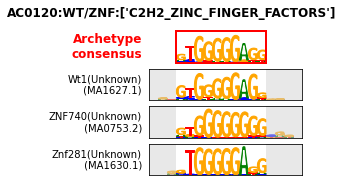

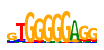

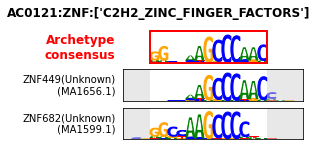

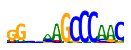

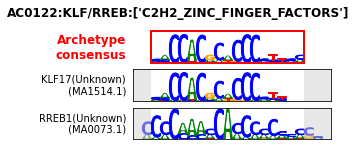

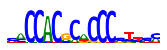

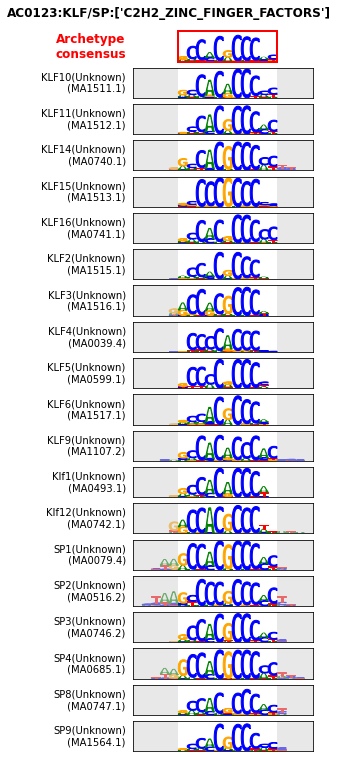

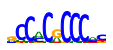

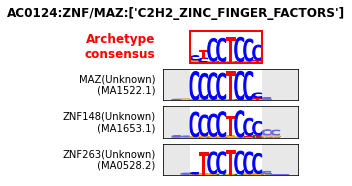

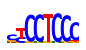

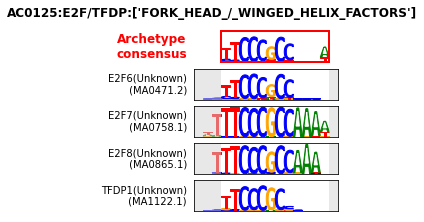

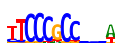

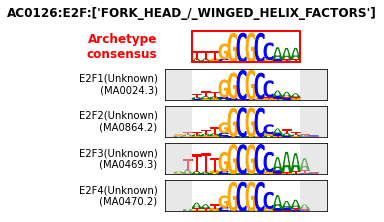

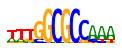

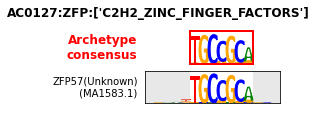

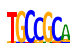

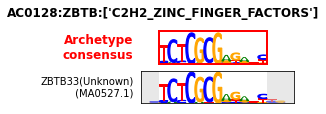

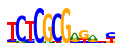

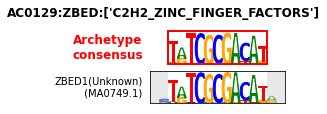

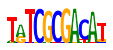

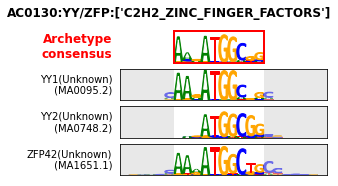

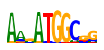

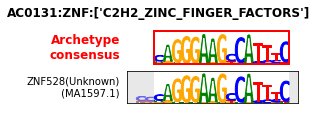

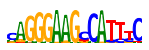

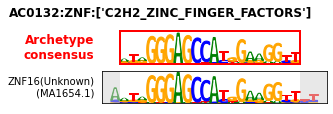

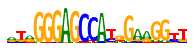

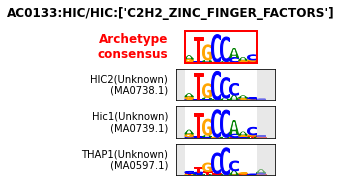

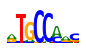

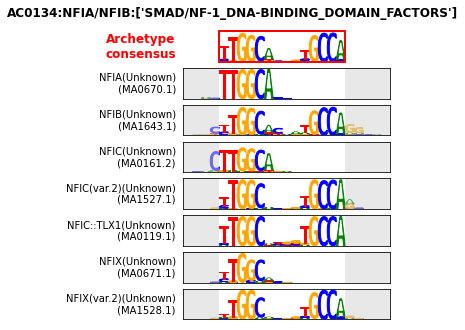

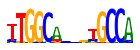

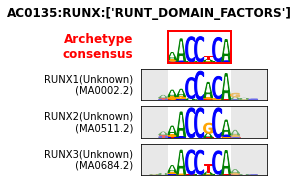

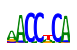

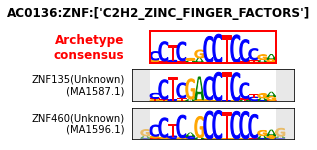

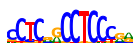

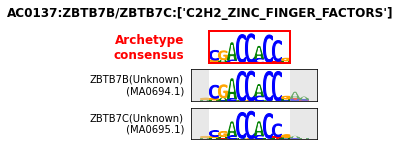

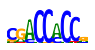

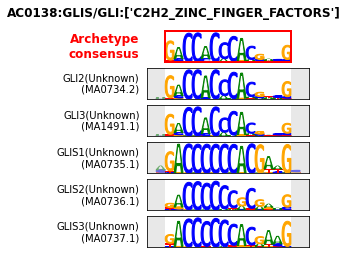

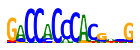

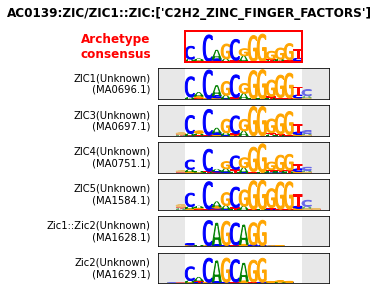

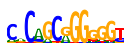

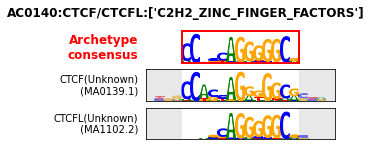

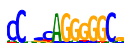

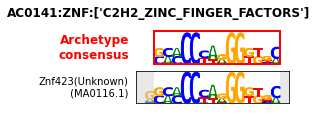

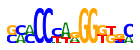

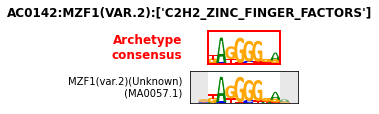

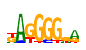

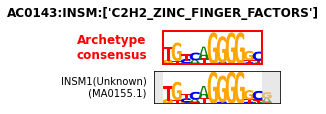

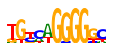

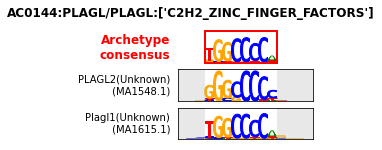

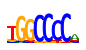

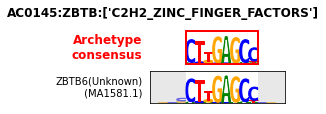

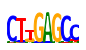

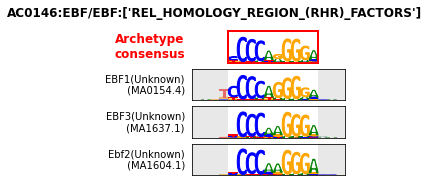

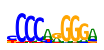

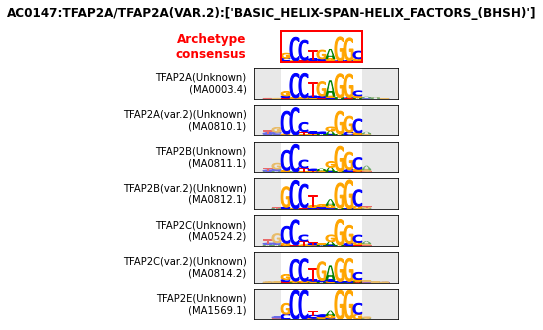

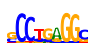

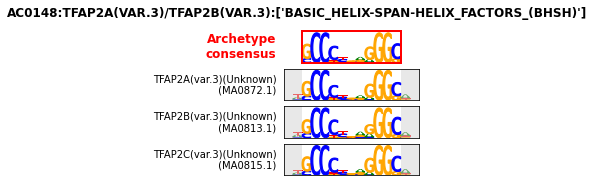

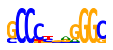

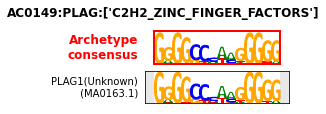

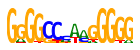

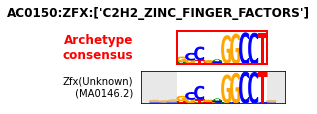

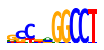

In [25]:
import matplotlib.pyplot as plt

with open('/tf_clustering/files/consensus_pwms.uniprobe', 'w') as fh:
    with plt.ioff():
        for cluster, df in motif_annot_df.groupby('cluster'):
            consensus_pwm = process_cluster(df, tomtom)
            fh.write(consensus_pwm + '\n\n')

In [26]:
# size = motif_annot_df.groupby('cluster').size()

terms = motif_annot_df.groupby('cluster').agg({'source_id': ' '.join, 'tf_name': ' '.join})
terms['n'] = motif_annot_df.groupby('cluster').size()
terms = terms[['n', 'source_id', 'tf_name']]

terms.sort_values(by='n', ascending=False).to_csv('/tf_clustering/files/clusters.txt', sep='\t', header=None, index=True)

In [27]:
terms[terms['source_id'].str.contains('RUNX')].index

Index([], dtype='object', name='cluster')

In [28]:
# Make the archetype motif MEME file

!uniprobe2meme /tf_clustering/files/consensus_pwms.uniprobe > /tf_clustering/files/consensus_pwms.meme

zsh:1: command not found: uniprobe2meme


In [29]:
# Output final motif metadata table

motif_annot_df.to_csv('/tf_clustering/files/metadata.tsv', header=True, index=True, sep='\t')

In [30]:
motif_annot_df.head()

cluster source_id    tf_name  \
motif_id                                
MA0002.2  AC0135  MA0002.2      RUNX1   
MA0003.4  AC0147  MA0003.4     TFAP2A   
MA0004.1  AC0058  MA0004.1       Arnt   
MA0006.1  AC0057  MA0006.1  Ahr::Arnt   
MA0007.3  AC0087  MA0007.3         Ar   

                                                family_name motif_type  \
motif_id                                                                 
MA0002.2                              [Runt domain factors]    Unknown   
MA0003.4            [Basic helix-span-helix factors (bHSH)]    Unknown   
MA0004.1            [Basic helix-loop-helix factors (bHLH)]    Unknown   
MA0006.1  [Basic helix-loop-helix factors (bHLH), Basic ...    Unknown   
MA0007.3           [Nuclear receptors with C4 zinc fingers]    Unknown   

              PMID  
motif_id            
MA0002.2         -  
MA0003.4  23332764  
MA0004.1   7592839  
MA0006.1   7592839  
MA0007.3  20943813

In [33]:
# Still TODO: Make the HTML files
!bash /tf_clustering/scripts/runall.make-html.modified